In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax , AdamW, SGD
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_dir = 'C:\py_works\wildfire_v2'

In [ ]:
train_dir = os.path.join(base_dir , 'train')
 

valid_dir= os.path.join(base_dir , 'validation')


test_dir = os.path.join(base_dir , 'test')


train_fire_dir = os.path.join(train_dir , 'fire')


train_nofire_dir = os.path.join(train_dir , 'nofire')


valid_fire_dir = os.path.join(valid_dir, 'fire')

valid_nofire_dir = os.path.join(valid_dir , 'nofire')


test_fire_dir = os.path.join(test_dir , 'fire')


test_nofire_dir = os.path.join(test_dir , 'nofire')


In [ ]:
import random

def custom_augment(image, rotation_range=10, width_shift_range=0.1, 
                  height_shift_range=0.1, zoom_range=0.1, 
                  horizontal_flip=True, fill_mode='nearest'):
 
    h, w = image.shape[:2]
    output = image.copy()
    

    if width_shift_range > 0:
        tx = np.random.uniform(-width_shift_range, width_shift_range) * w
    else:
        tx = 0
        

    if height_shift_range > 0:
        ty = np.random.uniform(-height_shift_range, height_shift_range) * h
    else:
        ty = 0
    

    angle = np.random.uniform(-rotation_range, rotation_range)
    

    zoom = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    

    M = cv2.getRotationMatrix2D((w/2, h/2), angle, zoom)
    M[0,2] += tx
    M[1,2] += ty
    

    border_mode = cv2.BORDER_REPLICATE if fill_mode == 'nearest' else cv2.BORDER_CONSTANT
    

    output = cv2.warpAffine(output, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=border_mode)
    

    if horizontal_flip and random.random() < 0.5:
        output = cv2.flip(output, 1)
        
    return output

In [ ]:
import tensorflow as tf
import tifffile as tiff


def alexnet_preprocess_input(x):
     normalized_image = (tf.cast(x, tf.float32) / 32767.5) - 1.0
    #  normalized_image = (tf.cast(x, tf.float32) / 65535.0)
    # normalized_image = (tf.cast(x, tf.float32) / 255.0)
    #  normalized_image = (tf.cast(x, tf.float32) / 127.5) - 1.0
     return normalized_image

def load_tiff_images_from_directory(directory, img_size=(224, 224)):
    images = []
    labels = []

    for label_dir in ['fire', 'nofire']:
        full_dir = os.path.join(directory, label_dir)
        label = 1 if label_dir == 'fire' else 0

        for filename in os.listdir(full_dir):
            if filename.lower().endswith('.tiff'):
                path = os.path.join(full_dir, filename)
                img = tiff.imread(path)

            
                img = tf.image.resize(img, img_size)

                
                if img.shape[-1] != 3:
                    img = tf.image.grayscale_to_rgb(tf.expand_dims(img, axis=-1))

               
                img = alexnet_preprocess_input(img)

                images.append(img)
                labels.append(label)

    return tf.stack(images), tf.convert_to_tensor(labels)



In [6]:
def create_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [ ]:
batch_size = 43

train_images, train_labels = load_tiff_images_from_directory(train_dir)
valid_images, valid_labels = load_tiff_images_from_directory(valid_dir)
test_images, test_labels = load_tiff_images_from_directory(test_dir)

augmented_images = []
for img in train_images:
    aug_img = custom_augment(img.numpy(),  
                           rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True)
    augmented_images.append(aug_img)

augmented_images = tf.stack(augmented_images)

train_dataset = create_dataset(augmented_images, train_labels, batch_size=batch_size, shuffle=True)
valid_dataset = create_dataset(valid_images, valid_labels, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(test_images, test_labels, batch_size=batch_size, shuffle=False)


In [8]:
for image_batch, label_batch in train_dataset.take(1):
    print("Image dtype:", image_batch.dtype)
    print("Label dtype:", label_batch.dtype)

Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


In [9]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:

for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)

Image batch shape: (43, 224, 224, 3)
Label batch shape: (43,)


In [ ]:
import numpy as np


min_val = float('inf')
max_val = -float('inf')


for batch_images, _ in train_dataset:
  
    batch_min = np.min(batch_images)
    batch_max = np.max(batch_images)
    
  
    min_val = min(min_val, batch_min)
    max_val = max(max_val, batch_max)


print(f"Minimum value in training data: {min_val}")
print(f"Maximum value in training data: {max_val}")


Minimum value in training data: -1.0
Maximum value in training data: 1.0


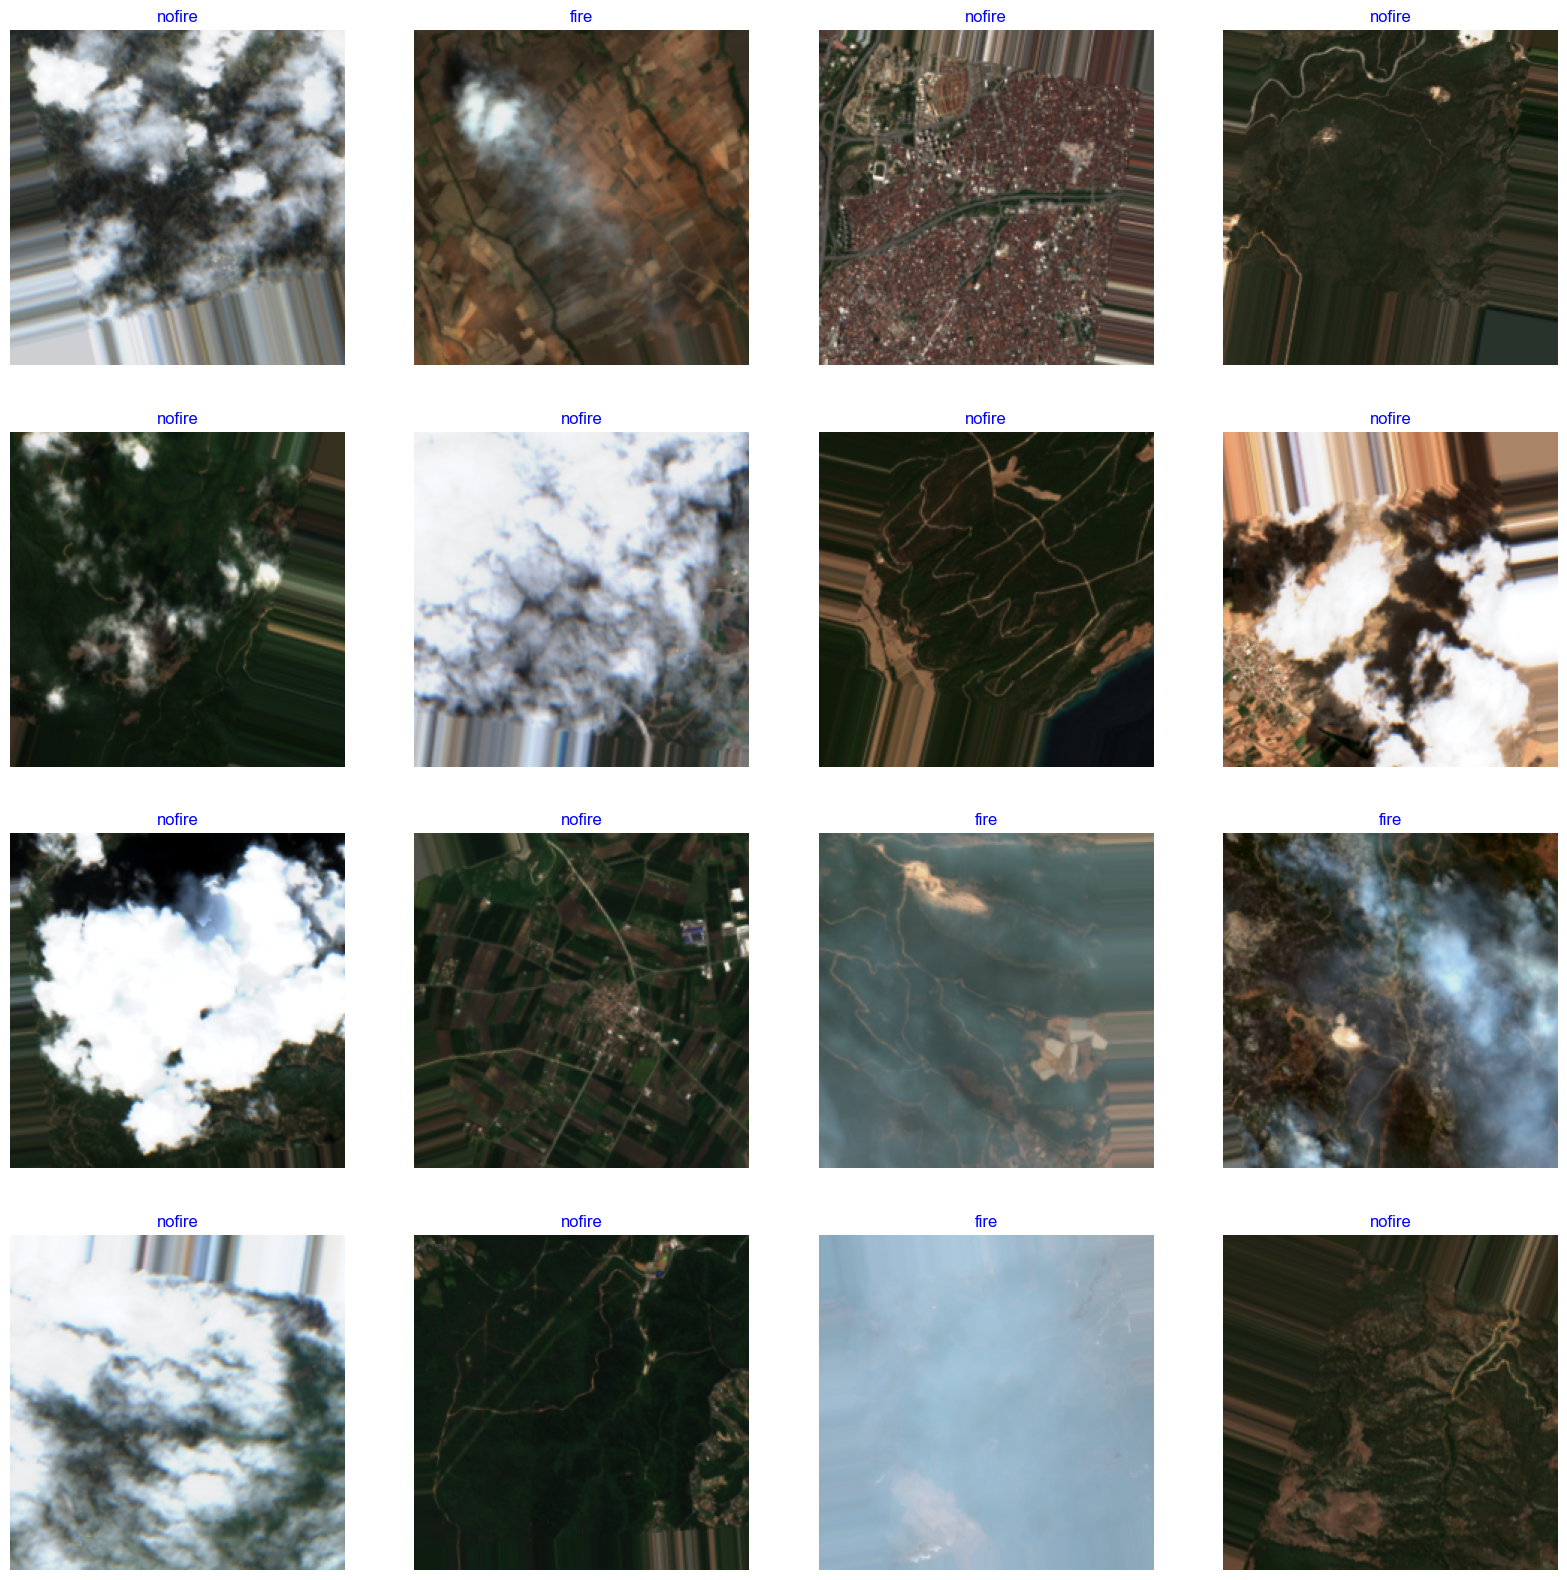

In [ ]:
classes = ["nofire", "fire"]

images, labels = next(iter(train_dataset))
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = (((images[i].numpy() + 1.0) * 127.5)).astype("uint8")  
    plt.imshow(image)
    class_index = int(labels[i].numpy())
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()


In [ ]:
img_shape = (224, 224, 3)  
num_classes = 1  

inputs = keras.Input(shape=(img_shape))
x = layers.Conv2D(filters=32,kernel_size=11,padding="same",use_bias=False)(inputs)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=3)(x)

x = layers.Conv2D(filters=64,kernel_size=5,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=3)(x)

x = layers.Conv2D(filters=128,kernel_size=5,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=192,kernel_size=3,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256,kernel_size=3,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=384,kernel_size=3,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)


x = layers.Flatten()(x)

x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="sigmoid")(x)

model = keras.Model(inputs=inputs,outputs=outputs)

In [22]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │        11,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 74, 74, 64)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 24, 24, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 192)    │       221,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 6, 6, 256)      │       442,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 3, 3, 384)      │       884,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 3, 3, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 1, 1, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 128)            │             

 Total params: 1,947,489 (7.43 MB)

 Trainable params: 1,947,489 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  
    monitor="val_accuracy",       
    mode="max",                   
    save_best_only=True,          
    verbose=0
)

plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    factor=.2,
    verbose=0
)

In [24]:
model.compile(AdamW(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history3 = model.fit(x= train_dataset, verbose=1, validation_data=valid_dataset,
                        epochs=200, callbacks=[early_stopping, plateau, model_checkpoint])

Epoch 1/200


10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5087 - loss: 0.6748 - val_accuracy: 0.5000 - val_loss: 0.7343 - learning_rate: 1.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5697 - loss: 0.6549 - val_accuracy: 0.5217 - val_loss: 0.7222 - learning_rate: 1.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7107 - loss: 0.5797 - val_accuracy: 0.5978 - val_loss: 0.6407 - learning_rate: 1.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7409 - loss: 0.4740 - val_accuracy: 0.6413 - val_loss: 0.5645 - learning_rate: 1.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8091 - loss: 0.4078 - val_accuracy: 0.7174 - val_loss: 0.5315 - learning_rate: 1.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8305 - loss: 0.3925 - val_accuracy: 0.7065 - val_loss: 0.5298 - learning_rate: 1.0000e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8507 - loss: 0.33

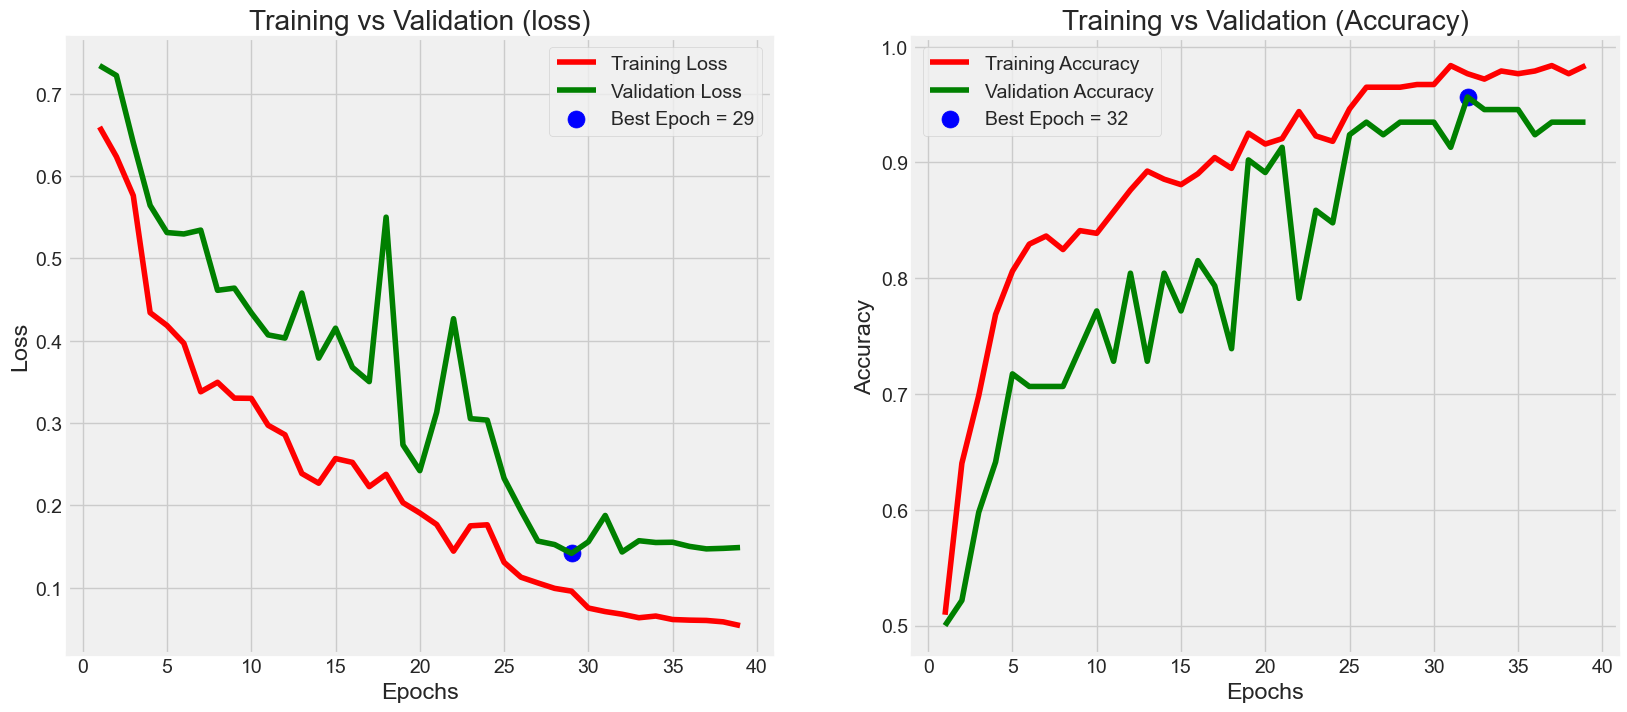

In [26]:
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']

val_acc = history3.history['val_accuracy']
val_loss = history3.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

In [27]:
train_score = model.evaluate(train_dataset , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_dataset , steps = 32 , verbose = 1)
test_score = model.evaluate(test_dataset , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9743 - loss: 0.0753
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9352 - loss: 0.1409 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9658 - loss: 0.1159 
Train loss = 0.07392866909503937
Train Accuracy = 0.9742990732192993
Validation loss = 0.14177176356315613
Validation Accuracy = 0.9347826242446899
Test loss = 0.11305267363786697
Test Accuracy = 0.9670329689979553


In [31]:
model = tf.keras.models.load_model("best_model.keras")

In [32]:
train_score = model.evaluate(train_dataset , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_dataset , steps = 32 , verbose = 1)
test_score = model.evaluate(test_dataset , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')



32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9850 - loss: 0.0588
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9578 - loss: 0.1414 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9658 - loss: 0.1154 
Train loss = 0.061330463737249374
Train Accuracy = 0.9836448431015015
Validation loss = 0.14342083036899567
Validation Accuracy = 0.95652174949646
Test loss = 0.11264872550964355
Test Accuracy = 0.9670329689979553


In [ ]:

preds = model.predict(test_dataset)


predicted_classes = (preds > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


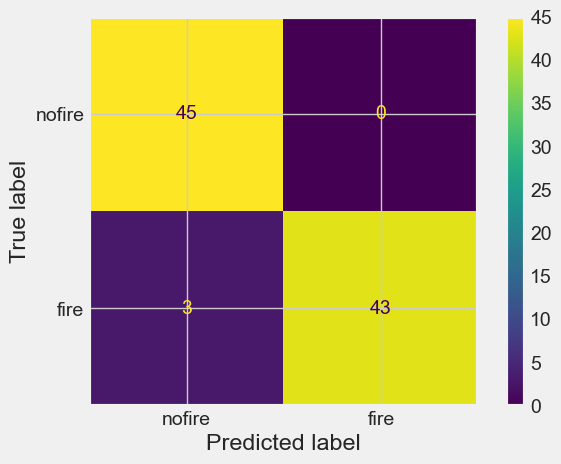

In [34]:
true_classes = []
for _, labels in test_dataset:
    true_classes.extend(labels.numpy())

true_classes = np.array(true_classes)

confusion = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["nofire", "fire"])
disp.plot(cmap='viridis', values_format='d')

In [35]:
from sklearn.metrics import classification_report

target_names = ['nofire', 'fire']
classification_rep = classification_report(true_classes, predicted_classes, target_names=target_names)
print("\nClassification Report:")
print(classification_rep)



Classification Report:
              precision    recall  f1-score   support

      nofire       0.94      1.00      0.97        45
        fire       1.00      0.93      0.97        46

    accuracy                           0.97        91
   macro avg       0.97      0.97      0.97        91
weighted avg       0.97      0.97      0.97        91



In [36]:
model.save("np_augmented_v2_lr_fs1.keras")

In [37]:
model = tf.keras.models.load_model("np_augmented_v2_lr_fs1.keras")

In [ ]:
from tensorflow.keras.preprocessing import image


img_path = "C:\py_works\content/img.tiff"
img = tiff.imread(img_path)
img = tf.image.resize(img, (224,224))
img = alexnet_preprocess_input(img)

img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
✅ No Wildfire.


In [40]:
prediction

array([[0.17042501]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image


img_path = "C:\py_works\content/img1.tiff"
img = tiff.imread(img_path)
img = tf.image.resize(img, (224,224))
img = alexnet_preprocess_input(img)


img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
✅ No Wildfire.


In [43]:
prediction

array([[2.979868e-05]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image


img_path = "C:\py_works\content/img2.tiff"
img = image.load_img(img_path, target_size=(224, 224))
img = alexnet_preprocess_input(img)


img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)


In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
✅ No Wildfire.


In [46]:
prediction

array([[0.17106712]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image


img_path = "C:\py_works\content/img5.tiff"
img = tiff.imread(img_path)
img = tf.image.resize(img, (224,224))
img = alexnet_preprocess_input(img)


img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
🔥 Wildfire Detected!


In [49]:
prediction

array([[0.6255414]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image

def default_preprocess(x):
    normalized_image = (tf.cast(x,tf.float32) / 127.5) - 1.0
    return normalized_image


img_path = "C:\py_works\content/img7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img = default_preprocess(img)
img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
🔥 Wildfire Detected!


In [52]:
prediction

array([[0.99986404]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image

def default_preprocess(x):
    normalized_image = (tf.cast(x,tf.float32) / 127.5) - 1.0
    return normalized_image


img_path = "C:\py_works\content/img8.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img = default_preprocess(img)
img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
🔥 Wildfire Detected!


In [55]:
prediction

array([[0.999223]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image

def default_preprocess(x):
    normalized_image = (tf.cast(x,tf.float32) / 127.5) - 1.0
    return normalized_image


img_path = "C:\py_works\content/img14.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img = default_preprocess(img)
img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
✅ No Wildfire.


In [58]:
prediction

array([[3.4639594e-08]], dtype=float32)